In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy 
import seaborn as sns
from typing import *
import pyodbc
import sqlalchemy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Q_PRACTICANTES_MODELO = '''
WITH C_EVA AS
(
    SELECT
        COD_SIGA,
        [ENPR-00100] as [ENPR-00100],
        [ENPR-00101] as [ENPR-00101],
        [ENPR-00102] as [ENPR-00102],
        [ENPR-00103] as [ENPR-00103],
        [ENPR-00104] as [ENPR-00104],
        [ENPR-00105] as [ENPR-00105],
        [ENPR-00106] as [ENPR-00106],
        [ENPR-00107] as [ENPR-00107],
        [ENPR-00108] as [ENPR-00108],
        [ENPR-00109] as [ENPR-00109],
        [ENPR-00110] as [ENPR-00110],
        [ENPR-00111] as [ENPR-00111]
    FROM 
        (SELECT COD_SIGA, COD_PREGUNTA, NOTA_CUANTI FROM Base_Prueba.dbo.EC_PR_2024) AS TABLA_FUENTE
    PIVOT
        (MAX(NOTA_CUANTI) FOR COD_PREGUNTA IN ([ENPR-00100], [ENPR-00101], [ENPR-00102], [ENPR-00103], [ENPR-00104], [ENPR-00105], [ENPR-00106], [ENPR-00107], [ENPR-00108], [ENPR-00109], [ENPR-00110], [ENPR-00111], [ENPR-00112], [ENPR-00113])) AS PIVOT_TABLE
)
SELECT 
    A.Cod_SIGA, 
    A.Matricula,
    A.tiempo_bcp AS TIEMPO_BCP,
    CASE
        WHEN A.tiempo_bcp <= 0.2 THEN '1. Desde 0 a 3 meses'
        WHEN A.tiempo_bcp <= 0.5 THEN '2. De 3 a 6 meses'
        WHEN A.tiempo_bcp <= 0.8 THEN '3. De 6 a 9 meses'
        WHEN A.tiempo_bcp <= 1 THEN '4. De 9 hasta 12 meses'
        WHEN A.tiempo_bcp <= 1.6 THEN '5. De 12 a 18 meses'
        ELSE '6. Mas de 18 meses'
    END RANGO_TIEMPO_BCP,
    A.Cod_GG, 
    A.Reporte_GG, 
    A.Cod_Division, 
    A.Nombre_Division, 
    A.Cod_Area, 
    A.Nombre_Area, 
    A.Cod_Servicio, 
    A.Nombre_Servicio, 
    A.Cod_UO, 
    A.Nombre_UO, 
    A.Sexo AS GENERO, 
    CASE
        WHEN A.Edad BETWEEN 18 AND 19 THEN '1. Entre 18 y 19 años'
        WHEN A.Edad BETWEEN 20 AND 21 THEN '2. Entre 20 y 21 años'
        WHEN A.Edad BETWEEN 22 AND 23 THEN '3. Entre 22 y 23 años'
        WHEN A.Edad BETWEEN 24 AND 25 THEN '4. Entre 24 y 25 años'
        WHEN A.Edad BETWEEN 26 AND 27 THEN '5. Entre 26 y 27 años'
        ELSE '6. Más de 28 años'
    END AS RANGO_EDAD,
    D.RANKING AS RK_UNIVERSIDAD,
    CASE
        WHEN D.RANKING <= 3 THEN '1. TOP INTERNACIONAL'
        WHEN D.RANKING <= 9 THEN '2. TOP 5 NACIONAL'
        WHEN D.RANKING <= 20 THEN '3. TOP 10 NACIONAL'
        WHEN D.RANKING <= 30 THEN '4. TOP 20 NACIONAL'
        WHEN D.RANKING <= 40 THEN '5. TOP 30 NACIONAL'
        ELSE '6. OTROS'
    END AS RANKING_UNIVERSIDAD,
    E.[ENPR-00100],
    E.[ENPR-00101],
    E.[ENPR-00102],
    E.[ENPR-00103],
    E.[ENPR-00104],
    E.[ENPR-00105],
    E.[ENPR-00106],
    E.[ENPR-00107],
    E.[ENPR-00108],
    E.[ENPR-00109],
    E.[ENPR-00110],
    E.[ENPR-00111],
    CASE
        WHEN B.NUM_DOCUMENTO IS NULL THEN 0
        ELSE 1
    END AS TARGET
FROM BCP_GDH_PA_DW.GENERAL.BASE_COMPLETA A
    LEFT JOIN BCP_GDH_PA_DW.GENERAL.D_COLABORADOR B 
        ON A.Num_Doc = B.NUM_DOCUMENTO AND B.TIPO_PREPER = 'Orgánico' AND DATEDIFF(MONTH, B.FEC_INGRESO_BANCO, A.Fec_Cese) BETWEEN 0 AND 12
    LEFT JOIN Base_Prueba.dbo.UP C
        ON A.Cod_SIGA = C.COD_SIGA
    LEFT JOIN Base_Prueba.dbo.UNIVERSIDADES D
        ON C.FK_UNIVERSIDAD = D.PK_ID
    LEFT JOIN C_EVA E ON A.COD_SIGA = E.COD_SIGA
WHERE 
    A.TIPO_PREPER = 'Practicante' AND 
    A.Sociedad = 'BCP Perú' AND 
    A.nxt_Tipo_PrePer = 'ultimo registro' AND
    A.STATUS = 'CESADO'
ORDER BY A.periodo DESC
'''

def get_mssql_conn(server_name: str = 'PAUTGSQLP43'):
    return pyodbc.connect('DRIVER={};SERVER={};TRUSTED_CONNECTION=YES;'.format('SQL SERVER', server_name))

def read_data(query) -> pd.DataFrame:
    conn = get_mssql_conn()
    return pd.read_sql_query(query, conn)

df_practicantes_model = read_data(Q_PRACTICANTES_MODELO) 

DIC_COL_PRACTIS = {
    'Cod_SIGA': 'COD_SIGA',
    'Matricula': 'MATRICULA',
    # 'Fec_Ingreso': 'FECHA_INGRESO',
    # 'Fec_Cese' : 'FECHA_CESE',
    'tiempo_bcp' : 'TIEMPO_BCP',
    'RANGO_TIEMPO_BCP' : 'RANGO_TIEMPO_BCP',
    'Cod_GG' : 'CÓDIGO_GERENCIA_GENERAL',
    'Cod_Division': 'COD_DIVISION',
    'Cod_Area' : 'COD_AREA',
    'Sexo' : 'GENERO',
    # 'Edad' : 'EDAD',
    'Rango_Edad' : 'RANGO_EDAD',
    # 'UNIVERSIDAD' : 'UNIVERSIDAD',
    'RK_UNIVERSIDAD' : 'RK_UNIVERSIDAD',
    'ENPR-00100' : 'ENPR-00100',
    'ENPR-00101' : 'ENPR-00101',
    'ENPR-00102' : 'ENPR-00102',
    'ENPR-00103' : 'ENPR-00103',
    'ENPR-00104' : 'ENPR-00104',
    'ENPR-00105' : 'ENPR-00105',
    'ENPR-00106' : 'ENPR-00106',
    'ENPR-00107' : 'ENPR-00107',
    'ENPR-00108' : 'ENPR-00108',
    'ENPR-00109' : 'ENPR-00109',
    'ENPR-00110' : 'ENPR-00110',
    'ENPR-00111' : 'ENPR-00111',
    'Target' : 'TARGET'
}

def columnas(df: pd.DataFrame, dic_cols: Dict[str, str]):
    df = df.rename(columns=dic_cols)
    arr_cols = [v for k,v in dic_cols.items()]
    df = df[arr_cols]
    return df

df_practicantes_model = columnas(df_practicantes_model, DIC_COL_PRACTIS)

df_practicantes_model

C:\Users\T41002\AppData\Local\Temp\ipykernel_9236\2933202913.py:119: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


,COD_SIGA,MATRICULA,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,GENERO,RANGO_EDAD,RK_UNIVERSIDAD,...,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,TARGET
0,00624801,0T24801,2.001368,6. Mas de 18 meses,00000534,00000534,00025237,Femenino,3. Entre 22 y 23 años,12.0,...,1.0,5.0,2.0,4.0,2.0,4.0,3.0,2.0,4.0,0
1,00630806,0T30806,1.620807,6. Mas de 18 meses,00000378,00000378,00000406,Masculino,3. Entre 22 y 23 años,6.0,...,3.0,2.0,4.0,4.0,2.0,5.0,4.0,4.0,3.0,1
2,00632394,0T32394,1.459274,5. De 12 a 18 meses,00019957,00019957,00018527,Femenino,3. Entre 22 y 23 años,6.0,...,1.0,5.0,1.0,1.0,3.0,2.0,3.0,2.0,1.0,0
3,00632845,0T32845,1.459274,5. De 12 a 18 meses,00019957,00019957,00018202,Femenino,2. Entre 20 y 21 años,6.0,...,3.0,1.0,4.0,3.0,1.0,1.0,4.0,2.0,4.0,1
4,00633468,0T33468,1.382614,5. De 12 a 18 meses,00000534,00000534,00028194,Masculino,2. Entre 20 y 21 años,13.0,...,3.0,2.0,3.0,1.0,5.0,3.0,2.0,3.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,00508435,0S08435,0.506502,3. De 6 a 9 meses,00012412,00012412,00014152,Femenino,3. Entre 22 y 23 años,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4616,00508438,0S08438,0.503764,3. De 6 a 9 meses,00002620,00000007,00000007,Femenino,2. Entre 20 y 21 años,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4617,00508458,0S08458,0.503764,3. De 6 a 9 meses,00000041,00000565,00000573,Femenino,3. Entre 22 y 23 años,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4618,00509041,0S09041,0.334017,2. De 3 a 6 meses,00000378,00003551,00022076,Masculino,2. Entre 20 y 21 años,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [3]:

# Valores a imputar
from sklearn.impute import KNNImputer

# Seleccionar las columnas relevantes para la imputación
columnas_imputar = ['RANGO_TIEMPO_BCP', 'CÓDIGO_GERENCIA_GENERAL', 'COD_DIVISION', 'COD_AREA', 'GENERO', 'RANGO_EDAD', 'TARGET']

# Convertir las columnas categóricas a numéricas
df_encoded = pd.get_dummies(df_practicantes_model[columnas_imputar], drop_first=True)

df_encoded['RK_UNIVERSIDAD'] = df_practicantes_model['RK_UNIVERSIDAD']

# Aplicar KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_encoded)

# Convertir el resultado a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df_encoded.columns)

df_practicantes_model['RK_UNIVERSIDAD'] = df_imputed['RK_UNIVERSIDAD']

lst_preguntas = ['ENPR-00100',
 'ENPR-00101',
 'ENPR-00102',
 'ENPR-00103',
 'ENPR-00104',
 'ENPR-00105',
 'ENPR-00106',
 'ENPR-00107',
 'ENPR-00108',
 'ENPR-00109',
 'ENPR-00110',
 'ENPR-00111']

columnas_imputar = ['RANGO_TIEMPO_BCP', 'CÓDIGO_GERENCIA_GENERAL', 'COD_DIVISION', 'COD_AREA', 'GENERO', 'RANGO_EDAD', 'RK_UNIVERSIDAD' ,'TARGET']

df_practicantes_model['RANKING_UNIVERSIDAD'] = df_practicantes_model['RK_UNIVERSIDAD'].apply(lambda x: '1. TOP INTERNACIONAL' if x <= 3 else '2. TOP 5 NACIONAL' if x <= 9 else '3. TOP 10 NACIONAL' if x <= 20 else '4. TOP 20 NACIONAL' if x <= 30 else '5. TOP 30 NACIONAL' if x <= 40 else '6. OTROS')

# Convertir las columnas categóricas a numéricas
df_encoded = pd.get_dummies(df_practicantes_model[columnas_imputar], drop_first=True)

for i in lst_preguntas:
    df_encoded[i] = df_practicantes_model[i]
    # Aplicar KNN Imputer
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = imputer.fit_transform(df_encoded)

    # Convertir el resultado a DataFrame
    df_imputed = pd.DataFrame(df_imputed, columns=df_encoded.columns)

    df_practicantes_model[i] = df_imputed[i]

df_practicantes_model

,COD_SIGA,MATRICULA,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,GENERO,RANGO_EDAD,RK_UNIVERSIDAD,...,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,TARGET,RANKING_UNIVERSIDAD
0,00624801,0T24801,2.001368,6. Mas de 18 meses,00000534,00000534,00025237,Femenino,3. Entre 22 y 23 años,12.0,...,5.0,2.0,4.0,2.0,4.0,3.0,2.0,4.0,0,3. TOP 10 NACIONAL
1,00630806,0T30806,1.620807,6. Mas de 18 meses,00000378,00000378,00000406,Masculino,3. Entre 22 y 23 años,6.0,...,2.0,4.0,4.0,2.0,5.0,4.0,4.0,3.0,1,2. TOP 5 NACIONAL
2,00632394,0T32394,1.459274,5. De 12 a 18 meses,00019957,00019957,00018527,Femenino,3. Entre 22 y 23 años,6.0,...,5.0,1.0,1.0,3.0,2.0,3.0,2.0,1.0,0,2. TOP 5 NACIONAL
3,00632845,0T32845,1.459274,5. De 12 a 18 meses,00019957,00019957,00018202,Femenino,2. Entre 20 y 21 años,6.0,...,1.0,4.0,3.0,1.0,1.0,4.0,2.0,4.0,1,2. TOP 5 NACIONAL
4,00633468,0T33468,1.382614,5. De 12 a 18 meses,00000534,00000534,00028194,Masculino,2. Entre 20 y 21 años,13.0,...,2.0,3.0,1.0,5.0,3.0,2.0,3.0,4.0,0,3. TOP 10 NACIONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,00508435,0S08435,0.506502,3. De 6 a 9 meses,00012412,00012412,00014152,Femenino,3. Entre 22 y 23 años,4.0,...,3.0,4.2,2.2,3.2,3.2,3.6,3.2,3.6,1,2. TOP 5 NACIONAL
4616,00508438,0S08438,0.503764,3. De 6 a 9 meses,00002620,00000007,00000007,Femenino,2. Entre 20 y 21 años,10.2,...,3.2,2.8,4.2,3.4,2.6,3.4,3.2,2.6,0,3. TOP 10 NACIONAL
4617,00508458,0S08458,0.503764,3. De 6 a 9 meses,00000041,00000565,00000573,Femenino,3. Entre 22 y 23 años,15.8,...,3.2,3.0,3.0,2.4,3.4,3.4,2.4,3.6,0,3. TOP 10 NACIONAL
4618,00509041,0S09041,0.334017,2. De 3 a 6 meses,00000378,00003551,00022076,Masculino,2. Entre 20 y 21 años,6.8,...,2.6,2.2,2.8,3.0,3.2,2.6,3.4,3.2,0,2. TOP 5 NACIONAL


In [7]:

df_num = df_practicantes_model.select_dtypes(include=[np.number]).copy()
df_cat = df_practicantes_model.select_dtypes(exclude=[np.number]).copy()


df_cat.columns
dict_columns_cat = {
    'RANGO_TIEMPO_BCP': 'RANGO_TIEMPO_BCP',
    'CÓDIGO_GERENCIA_GENERAL': 'CÓDIGO_GERENCIA_GENERAL',
    'COD_DIVISION': 'COD_DIVISION',
    'COD_AREA': 'COD_AREA',
    'GENERO': 'GENERO',
    'RANGO_EDAD': 'RANGO_EDAD',
    'RANKING_UNIVERSIDAD': 'RANKING_UNIVERSIDAD'
}
df_cat = columnas(df_cat, dict_columns_cat)

# Correción del atípico
tope_alto = round(df_num['TIEMPO_BCP'].quantile(0.99), 2)
df_num['TIEMPO_BCP'] = df_num['TIEMPO_BCP'].apply(lambda x: tope_alto if x > tope_alto else x)

###########################
## DATA TRANSFORMATION
###########################

columnascat = ['RANGO_TIEMPO_BCP','GENERO','RANGO_EDAD', 'RANKING_UNIVERSIDAD']
df_cat = df_cat[columnascat]

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

oneHE = OneHotEncoder(sparse=False, drop='first',dtype='int64')
df_oneHE = oneHE.fit_transform(df_cat[['GENERO']])

df_oneHE_genero = pd.DataFrame(df_oneHE, columns=oneHE.get_feature_names_out(['GENERO']))
df_oneHE_genero.rename(columns={'GENERO_Masculino': 'GENERO'}, inplace=True)


columnsOrdinalEncoder = ['RANGO_TIEMPO_BCP', 'RANGO_EDAD', 'RANKING_UNIVERSIDAD']
df_cat = df_cat[columnsOrdinalEncoder]
ordinal_encoder = OrdinalEncoder()
df_orden = ordinal_encoder.fit_transform(df_cat[columnsOrdinalEncoder])
df_orden = pd.DataFrame(df_orden, columns=columnsOrdinalEncoder)

from sklearn.preprocessing import MinMaxScaler

columnas_num = ['TIEMPO_BCP','TARGET','ENPR-00100','ENPR-00101','ENPR-00102','ENPR-00103','ENPR-00104','ENPR-00105','ENPR-00106','ENPR-00107','ENPR-00108','ENPR-00109','ENPR-00110','ENPR-00111']
mms = MinMaxScaler()
mms.fit(df_num[columnas_num])
df_mms = mms.transform(df_num[columnas_num])
df_mms = pd.DataFrame(df_mms, columns=columnas_num)

df_final = pd.concat([df_mms,df_orden,df_oneHE_genero],axis=1)

c:\Users\T41002\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


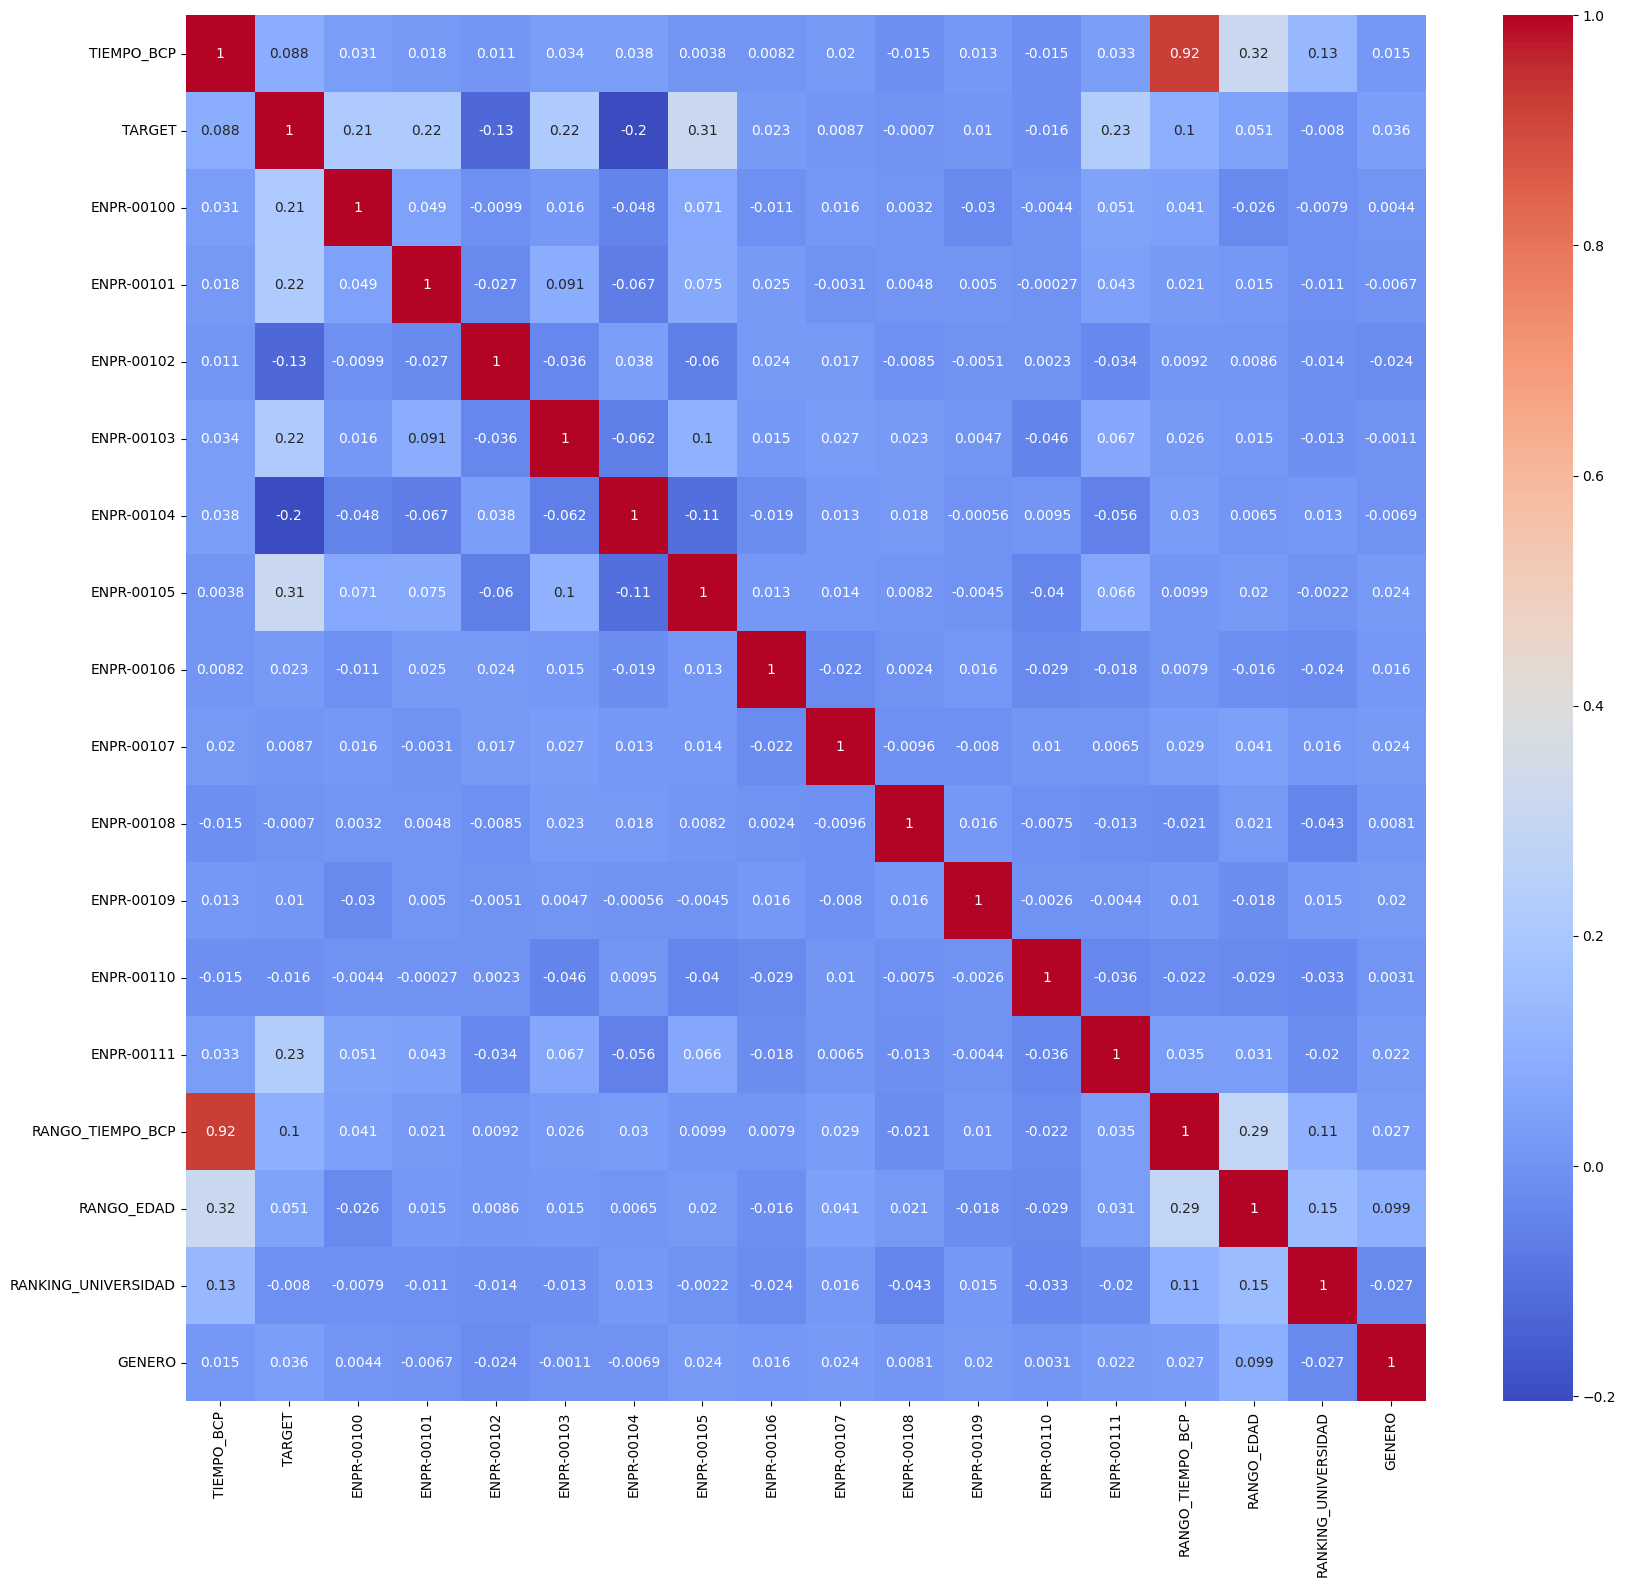

<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

correlacion = df_final.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.show()

# Guardar la imagen
plt.savefig('heatmap_correlacion.png')

# Mostrar la imagen
plt.show()

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes tu DataFrame df_final y has calculado la correlación
correlacion = df_final.corr()

# Obtener las correlaciones con 'target' y seleccionar las más altas
correlacion_target = correlacion['TARGET'].sort_values(ascending=False)
top_correlaciones = correlacion_target.head(10)  # Cambia el número para obtener más o menos variables

# Crear un DataFrame con las correlaciones
top_correlaciones_df = pd.DataFrame(top_correlaciones).reset_index()
top_correlaciones_df.columns = ['Variable', 'Correlación']

# Mostrar el DataFrame
print(top_correlaciones_df)

# Opcional: guardar el DataFrame en un archivo CSV
top_correlaciones_df.to_csv('top_correlaciones.csv', index=False)


           Variable  Correlación
0            TARGET     1.000000
1        ENPR-00105     0.310153
2        ENPR-00111     0.231640
3        ENPR-00103     0.218333
4        ENPR-00101     0.216362
5        ENPR-00100     0.205614
6  RANGO_TIEMPO_BCP     0.100773
7        TIEMPO_BCP     0.087598
8        RANGO_EDAD     0.050718
9            GENERO     0.035570


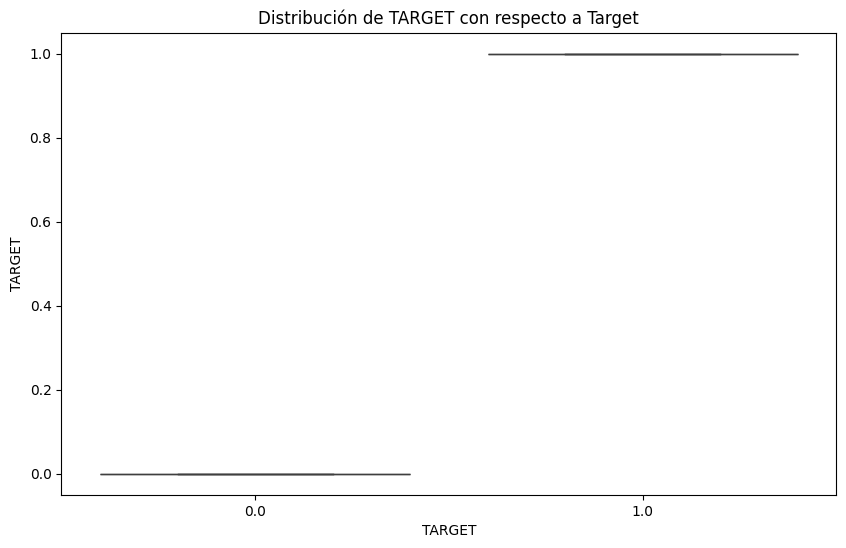

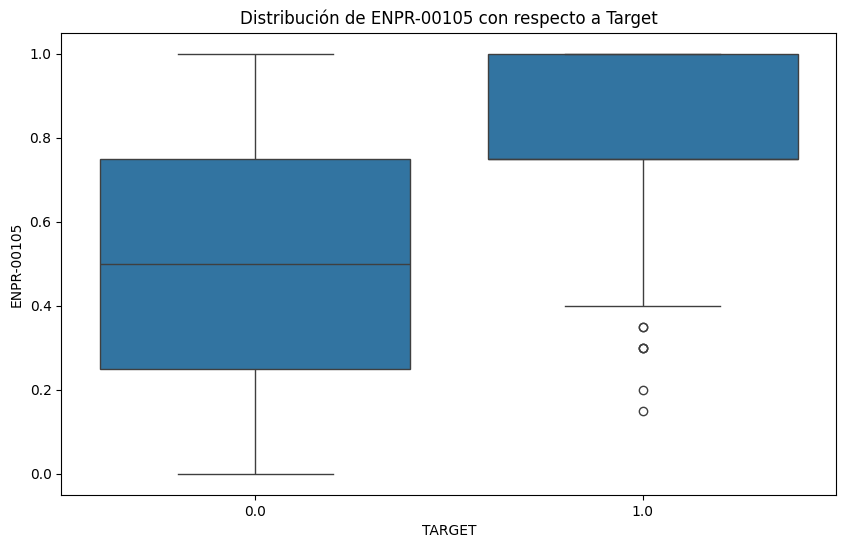

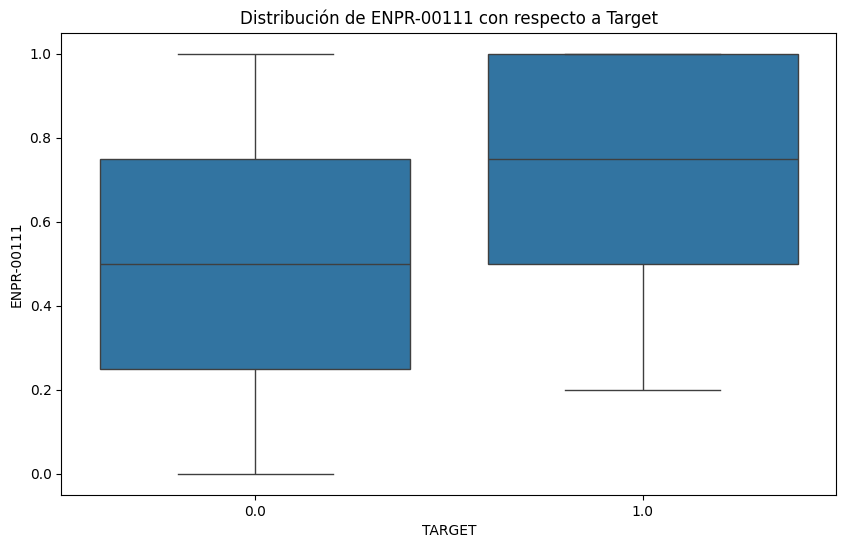

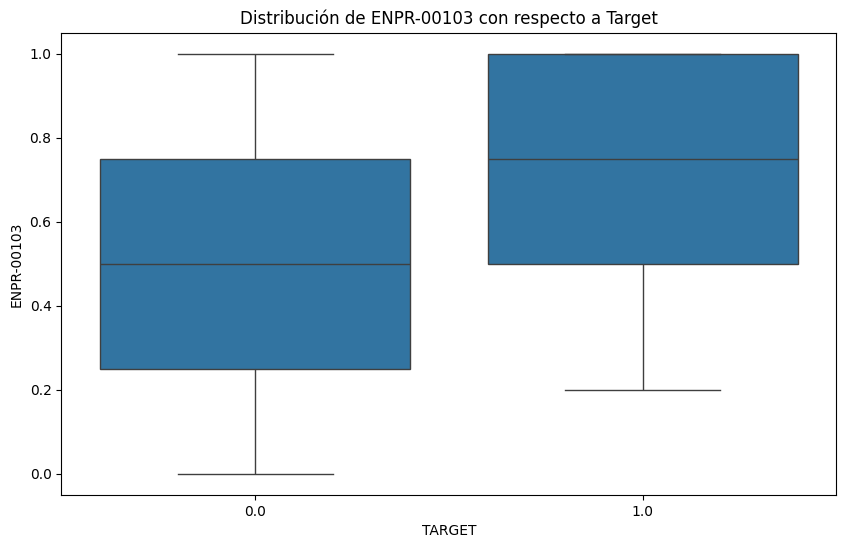

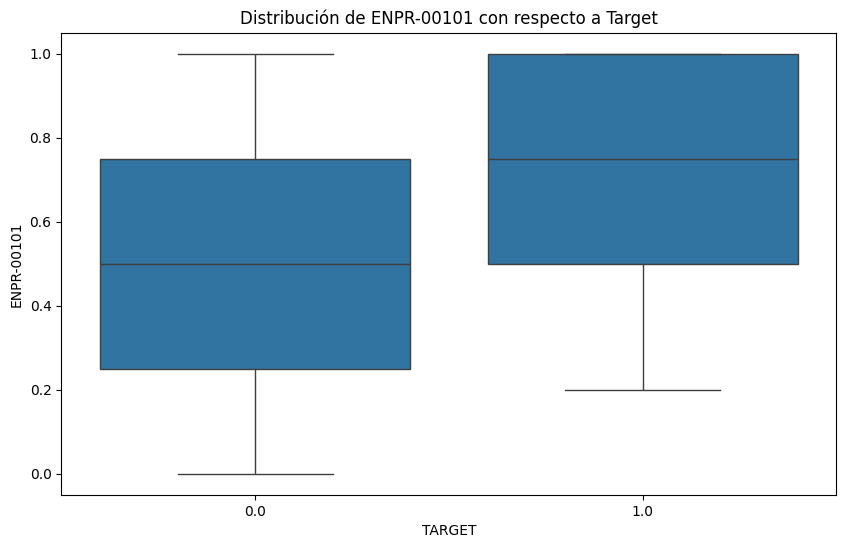

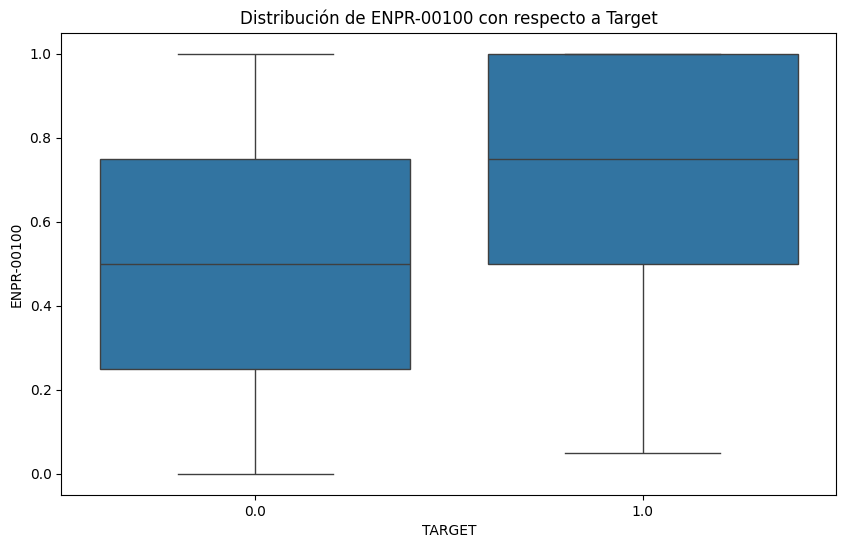

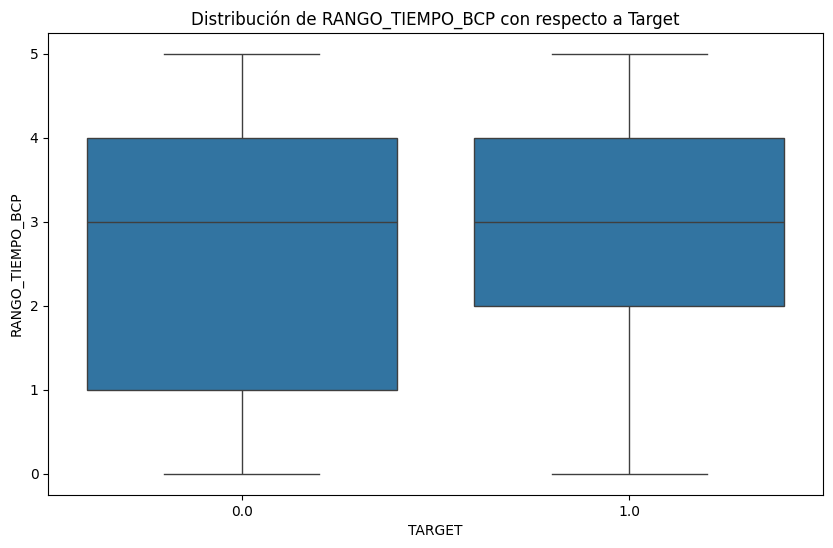

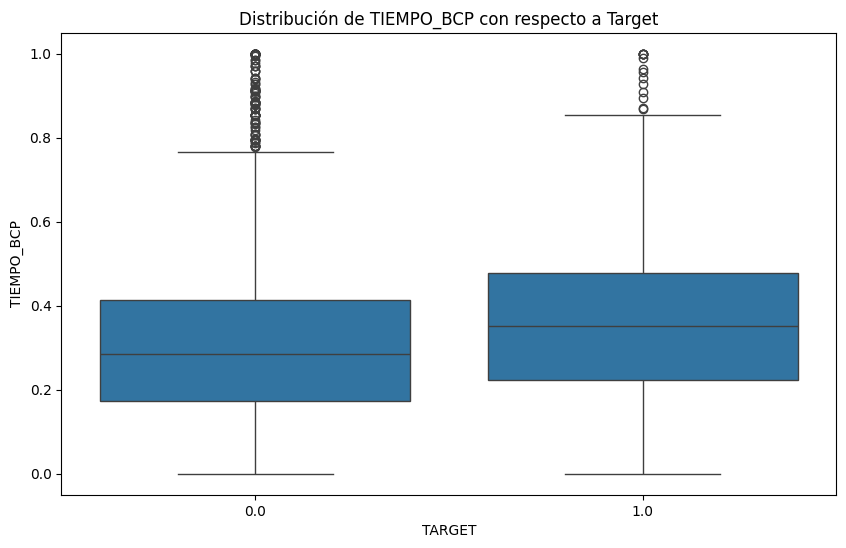

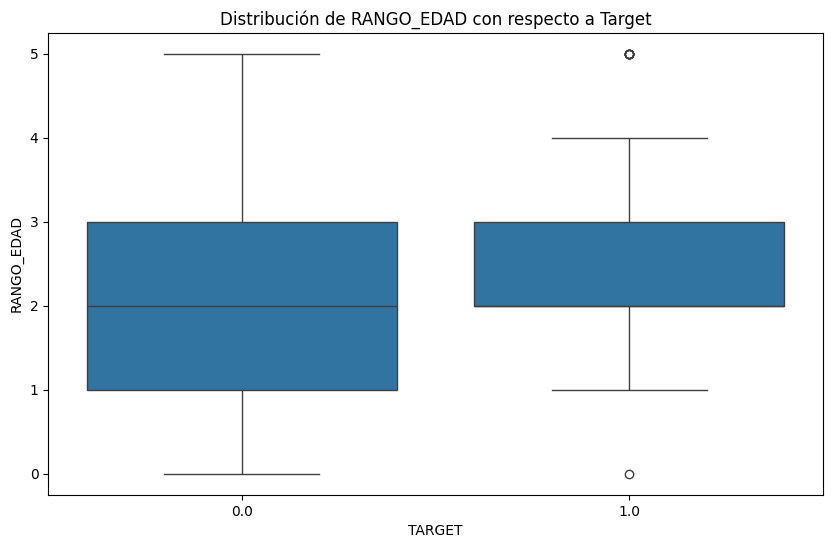

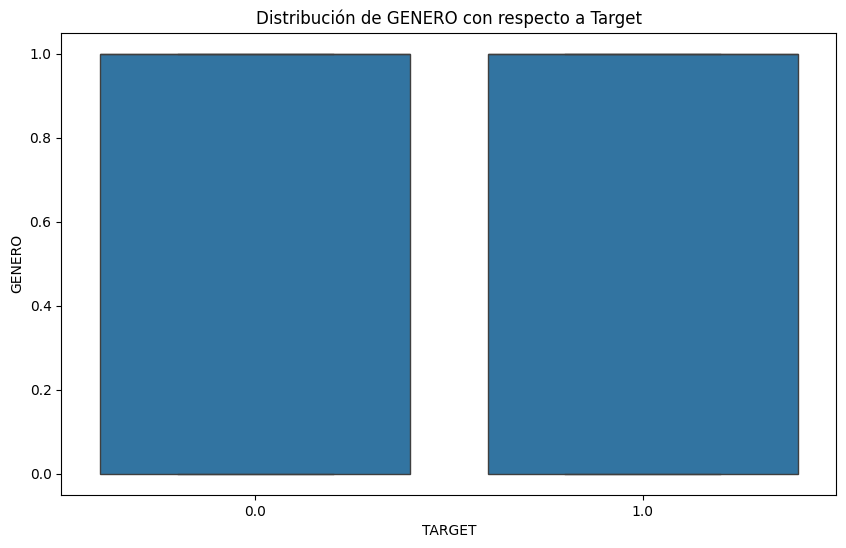

In [33]:
# Crear un boxplot para cada variable más correlacionada
for variable in top_correlaciones_df['Variable']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TARGET', y=variable, data=df_final)
    plt.title(f'Distribución de {variable} con respecto a Target')
    plt.savefig(f'boxplot_{variable}_target.png')
    plt.show()


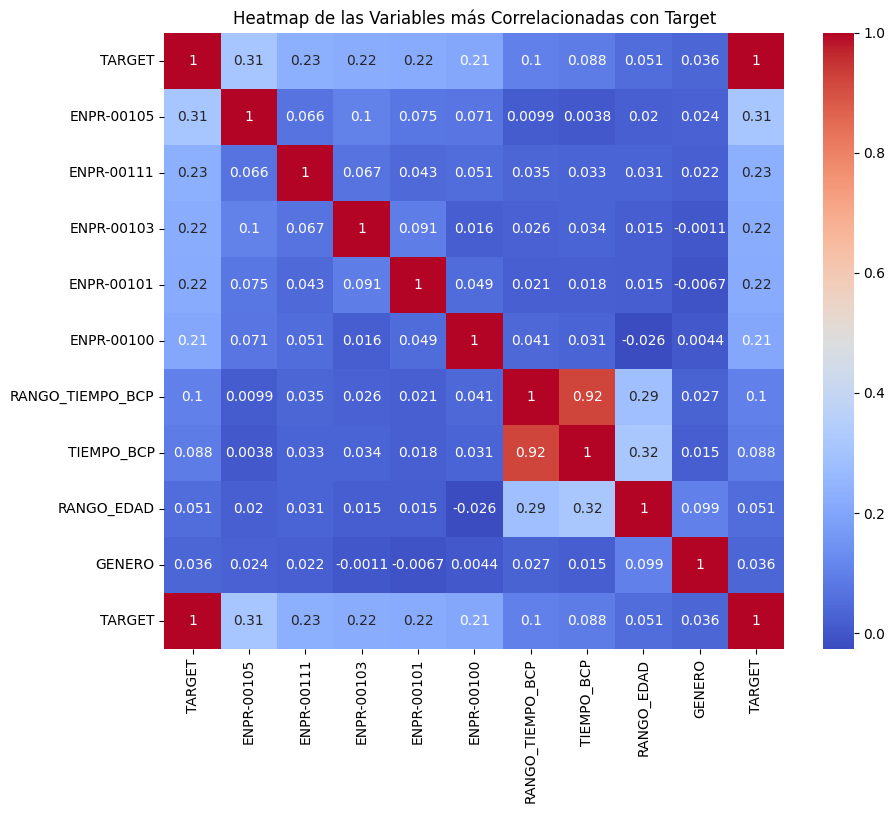

In [36]:
# Crear un heatmap con las variables más correlacionadas
subset = df_final[top_correlaciones_df['Variable'].tolist() + ['TARGET']]
correlacion_subset = subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_subset, annot=True, cmap='coolwarm')
plt.title('Heatmap de las Variables más Correlacionadas con Target')
plt.savefig('heatmap_correlacion_subset.png')
plt.show()


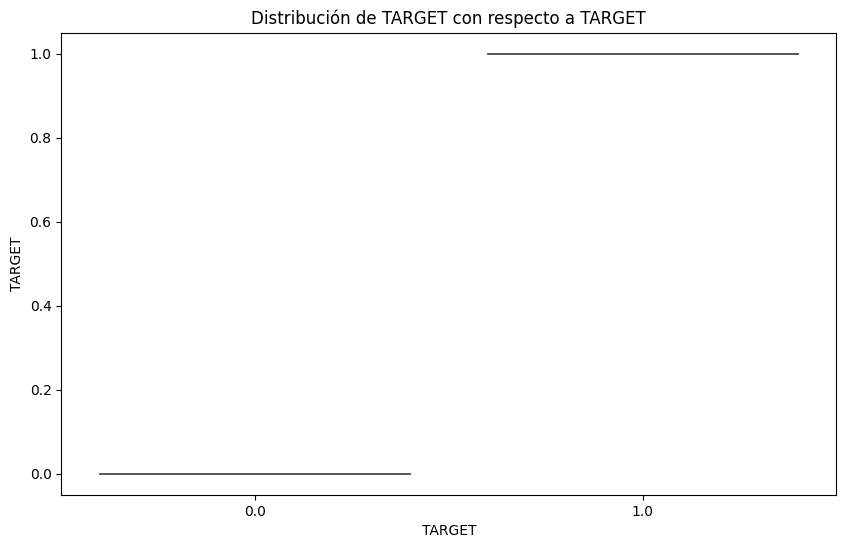

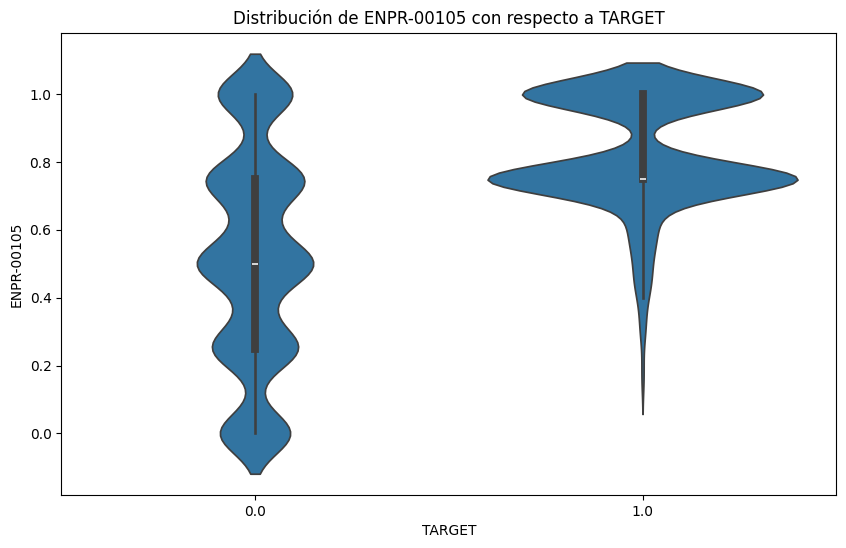

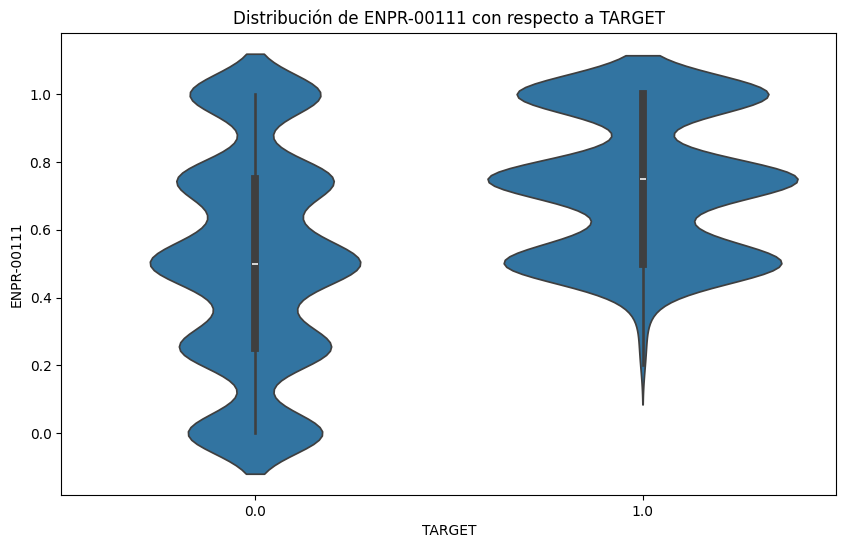

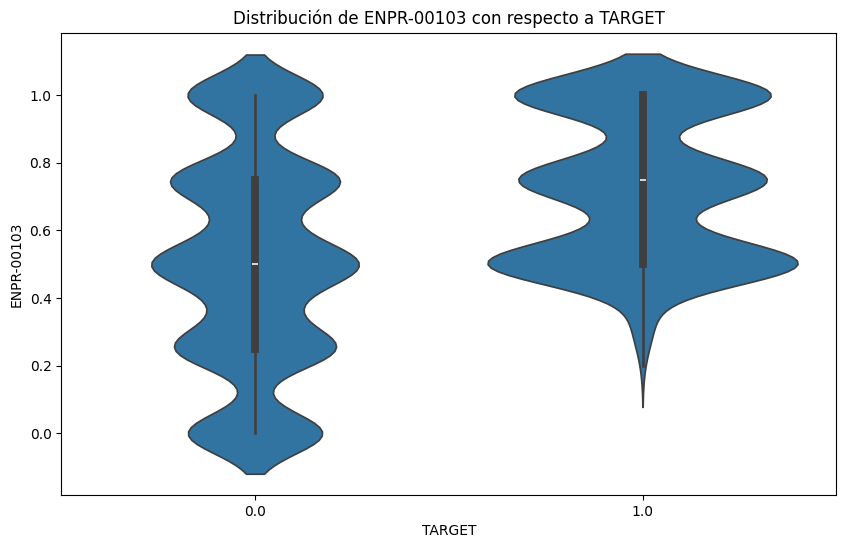

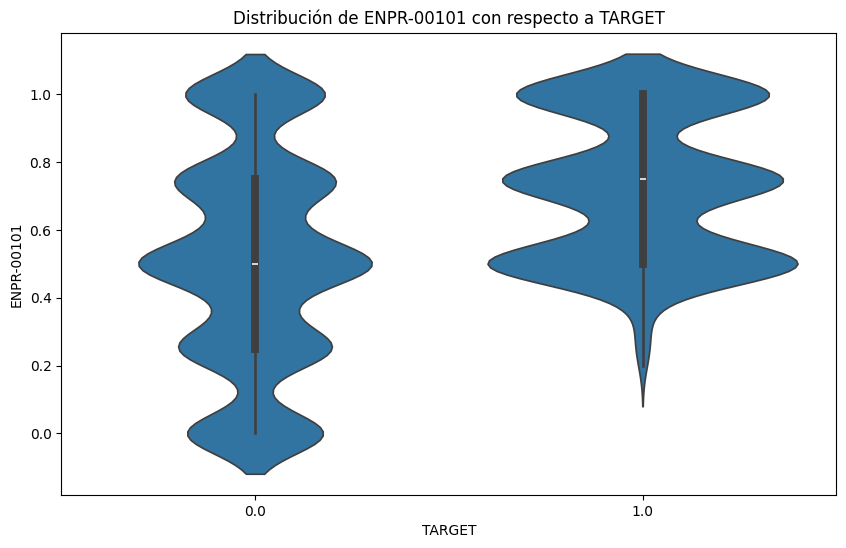

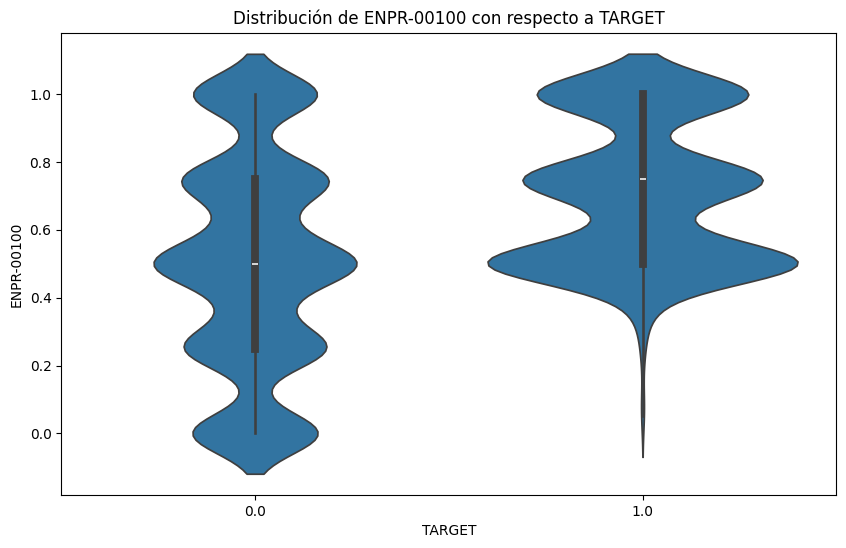

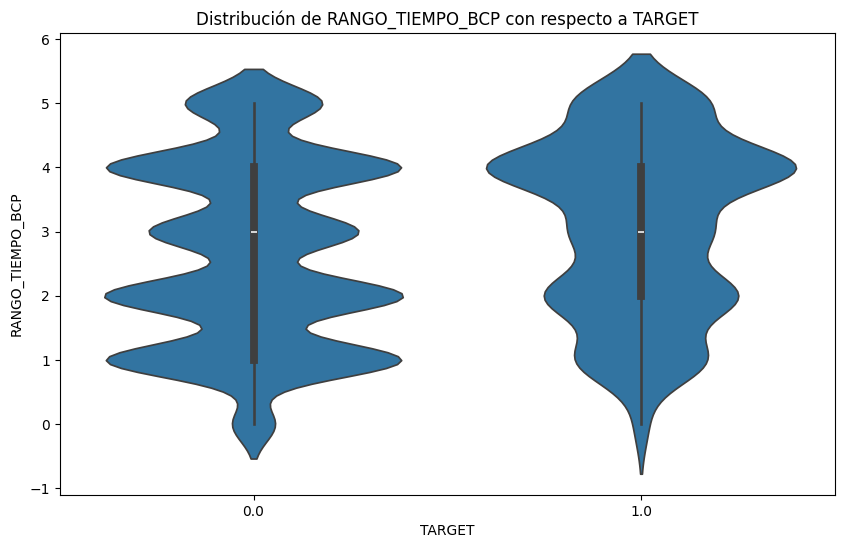

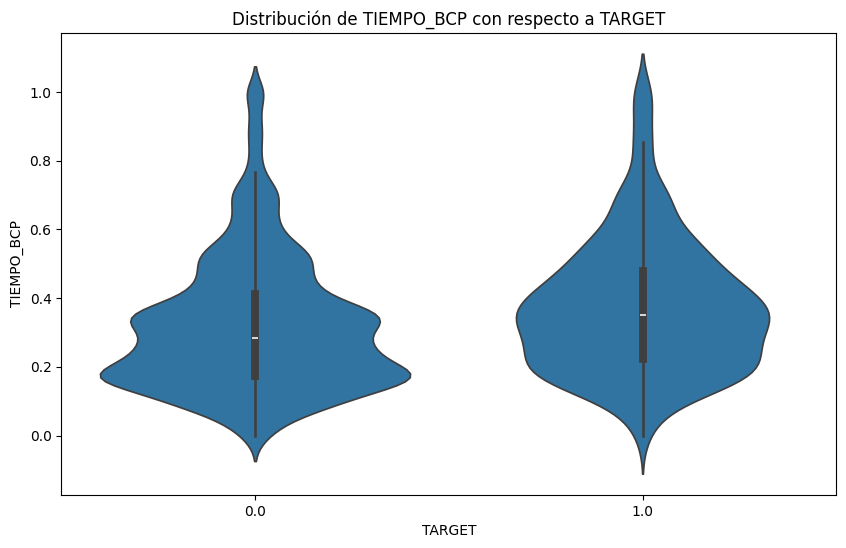

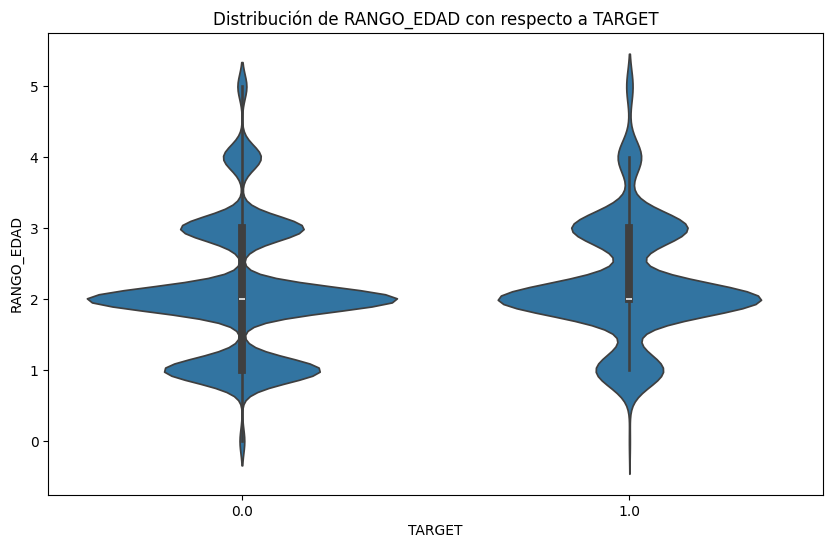

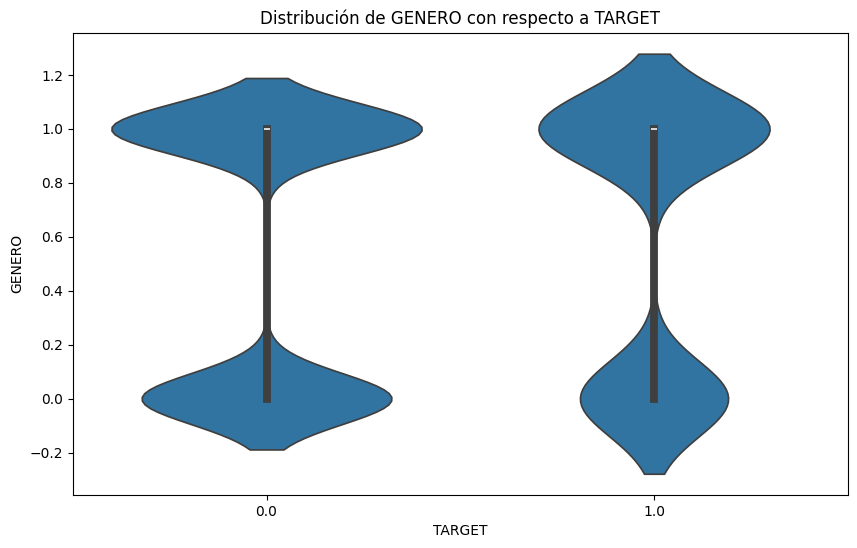

In [40]:
# Crear violin plots para las variables más correlacionadas
for variable in top_correlaciones_df['Variable']:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='TARGET', y=variable, data=df_final)
    plt.title(f'Distribución de {variable} con respecto a TARGET')
    plt.savefig(f'violinplot_{variable}_target.png')
    plt.show()


In [42]:
x = df_final.drop('TARGET', axis=1)
y = df_final['TARGET']

# MODELO

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=42)

rf = RandomForestClassifier(random_state=42)

# Definir los modelos base
rf = RandomForestClassifier()
xgb = XGBClassifier()
log_reg = LogisticRegression()

# Definir los hiperparámetros para cada modelo base
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10]
}

param_grid_log_reg = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Realizar la búsqueda de hiperparámetros
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')

grid_rf.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_log_reg.fit(X_train, y_train)

# Obtener los mejores modelos
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_log_reg = grid_log_reg.best_estimator_

# Definir el modelo de stacking
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('log_reg', best_log_reg)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Entrenar el modelo de stacking
stacking_clf.fit(X_train, y_train)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=20,
                                                       min_samples_split=5,
                                                       n_estimators=200)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=...
                                              learning_rate=0.01, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('log_reg',
                                LogisticRegression(C=10, solver='liblinear'))],
                   final_estimator=LogisticRegression())

Accuracy: 0.9747
Precision: 0.9190
Recall: 0.8474
F1 Score: 0.8818
ROC AUC: 0.9815


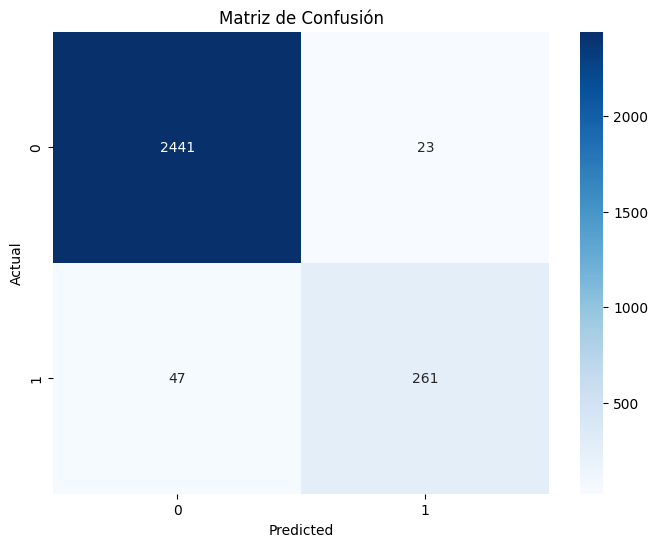

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2464
         1.0       0.92      0.85      0.88       308

    accuracy                           0.97      2772
   macro avg       0.95      0.92      0.93      2772
weighted avg       0.97      0.97      0.97      2772



In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predecir en el conjunto de prueba
y_pred = stacking_clf.predict(X_test)
y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Imprimir las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred))

In [47]:
df1 = df_final[df_final['TARGET'] == 1]
df1

,TIEMPO_BCP,TARGET,ENPR-00100,ENPR-00101,ENPR-00102,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,RANGO_TIEMPO_BCP,RANGO_EDAD,RANKING_UNIVERSIDAD,GENERO
1,0.572310,1.0,1.00,0.50,0.50,0.50,0.25,0.75,0.75,0.25,1.00,0.75,0.75,0.50,5.0,2.0,1.0,1
3,0.515176,1.0,0.50,0.75,0.00,0.50,0.00,0.75,0.50,0.00,0.00,0.75,0.25,0.75,4.0,1.0,1.0,0
20,0.218853,1.0,0.75,0.75,0.00,0.75,0.50,0.75,0.75,0.75,0.75,0.50,0.50,0.75,2.0,2.0,1.0,0
24,0.147193,1.0,1.00,1.00,0.50,0.50,0.00,1.00,0.25,0.00,0.75,0.25,0.50,0.50,1.0,2.0,1.0,0
35,0.295355,1.0,0.75,0.75,0.75,0.50,0.50,0.75,0.50,0.00,0.00,0.75,0.25,0.50,3.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4585,0.372825,1.0,0.60,0.85,0.50,0.80,0.30,0.55,0.55,0.30,0.25,0.45,0.50,0.80,4.0,2.0,1.0,1
4591,0.612982,1.0,0.70,0.60,0.45,0.50,0.20,0.80,0.60,0.35,0.20,0.55,0.45,0.75,5.0,2.0,1.0,1
4596,0.235315,1.0,0.25,0.65,0.60,0.75,0.10,0.45,0.35,0.40,0.45,0.60,0.45,0.75,2.0,2.0,1.0,0
4598,0.178181,1.0,0.35,0.45,0.70,0.50,0.35,0.55,0.50,0.50,0.60,0.50,0.40,0.55,2.0,2.0,2.0,1


In [ ]:
¿Por qué usar pickle?
Persistencia: Guardar el modelo entrenado permite que puedas cargarlo y usarlo más tarde sin tener que volver a entrenarlo.
Compartir: Puedes compartir el archivo pkl con otros, quienes pueden cargar el modelo y usarlo directamente.
Eficiencia: Ahorras tiempo y recursos al no tener que entrenar el modelo desde cero cada vez que lo necesites.